# Lung and Colon Cancer Classification
## About Dataset
This dataset contains 25,000 histopathological images with 5 classes. All images are 768 x 768 pixels in size and are in jpeg file format.
The images were generated from an original sample of HIPAA compliant and validated sources, consisting of 750 total images of lung tissue (250 benign lung tissue, 250 lung adenocarcinomas, and 250 lung squamous cell carcinomas) and 500 total images of colon tissue (250 benign colon tissue and 250 colon adenocarcinomas) and augmented to 25,000 using the Augmentor package.
There are five classes in the dataset, each with 5,000 images, being:

* Lung benign tissue
* Lung adenocarcinoma
* Lung squamous cell carcinoma
* Colon adenocarcinoma
* Colon benign tissue


How to Cite this Dataset
If you use in your research, please credit the author of the dataset:

Original Article
Borkowski AA, Bui MM, Thomas LB, Wilson CP, DeLand LA, Mastorides SM. Lung and Colon Cancer Histopathological Image Dataset (LC25000). arXiv:1912.12142v1 [eess.IV], 2019

Relevant Links
https://arxiv.org/abs/1912.12142v1
https://github.com/tampapath/lung_colon_image_set
Dataset BibTeX
@article{,
title= {LC25000 Lung and colon histopathological image dataset},
keywords= {cancer,histopathology},
author= {Andrew A. Borkowski, Marilyn M. Bui, L. Brannon Thomas, Catherine P. Wilson, Lauren A. DeLand, Stephen M. Mastorides},
url= {https://github.com/tampapath/lung_colon_image_set}
}


## Imports

In [ ]:
import os

import hydra
import lightning as pl
import matplotlib.pyplot as plt
import numpy as np
import pyrootutils
import torch
from hydra import compose, initialize
from omegaconf import OmegaConf

root = pyrootutils.setup_root(
    search_from=os.path.dirname(os.getcwd()),
    indicator=[".git", "pyproject.toml"],
    pythonpath=True,
    dotenv=True,
)


os.chdir(root)

torch.set_float32_matmul_precision("medium")

In [2]:
!pwd

/home/ultron/AI/practice-projects/CV/lung-and-colon-cancer-classification-pytorch


## Download datasets

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# https://gist.github.com/bdsaglam/586704a98336a0cf0a65a6e7c247d248

with initialize(
    version_base="1.3",
    config_path="../configs",
):
    cfg = compose(config_name="eval")
    print(cfg.paths.train_processed_dir)

datasets/processed/train


In [5]:
# set seed for random number generators in pytorch, numpy and python.random
if cfg.get("seed"):
    pl.seed_everything(cfg.seed, workers=True)

Seed set to 42


## Loading Images

In [6]:
CLASS_NAMES = [
    "colon-adenocarcinoma",
    "colon-benign-tissue",
    "lung-adenocarcinoma",
    "lung-benign-tissue",
    "lung-squamous-cell-carcinoma",
]

## Test Dataset Loading

In [7]:
data_module: pl.LightningDataModule = hydra.utils.instantiate(cfg.datamodule)
data_module.setup()

## Loading the model

In [8]:
input_shape = [3] + hydra.utils.instantiate(cfg.data.train_preprocess_transforms[1].size)
OmegaConf.update(cfg.model.net, "input_shape", input_shape, merge=True)

In [9]:
checkpoint = torch.load(cfg.ckpt_path, weights_only=False)
model: pl.LightningModule = hydra.utils.instantiate(cfg.model)
model.compile_model()
model.load_state_dict(checkpoint["state_dict"])
# disable grads + batchnorm + dropout
torch.set_grad_enabled(False)
model.eval()

/home/ultron/AI/practice-projects/CV/lung-and-colon-cancer-classification-pytorch/.venv/lib/python3.12/site-packages/pytorch_lightning/utilities/parsing.py:209: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.


LungColonCancerClassifier(
  (net): OptimizedModule(
    (_orig_mod): CustomConvNet(
      (conv_layers): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (4): Dropout(p=0.1, inplace=False)
        (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (7): ReLU()
        (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (9): Dropout(p=0.1, inplace=False)
        (10): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (11): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (12): ReLU()
      

In [10]:
test_data = data_module.test_dataloader()

In [11]:
all_preds = []
all_labels = []
images = []
test_data = data_module.test_dataloader()
for batch in test_data:
    x, y = batch
    images.append(x)
    pred = model(x)
    all_preds.append(pred)
    all_labels.append(y)

In [12]:
all_images = torch.cat(images)
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

In [ ]:
rand_indices = np.random.randint(0, len(all_preds), 16)

array([ 860, 1294, 1130, 1095, 1638, 2169,  466, 1238,  330, 1482, 2135,
        130, 1685,  769, 2391, 1515])

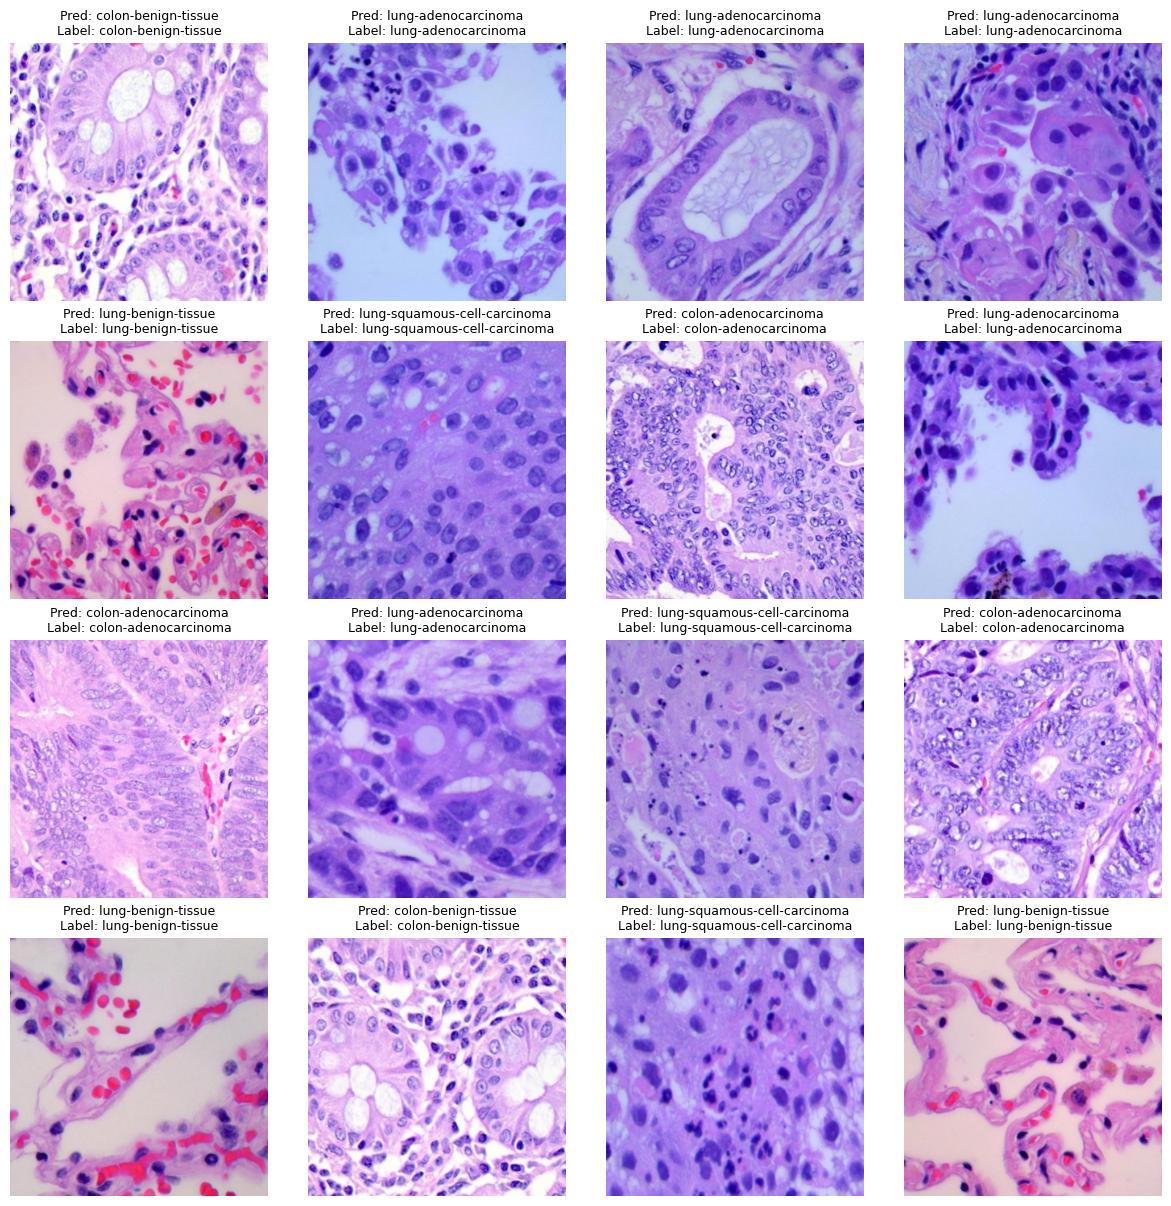

In [ ]:
def plot_selected_images(images_tensor, preds_tensor, labels_tensor, indices_to_plot):
    """
    Plots a grid of selected images with their predicted and true labels as titles.

    Args:
        images_tensor (torch.Tensor): Tensor containing all images.
                                      Expected shape like (N, C, H, W), (N, H, W, C), or (N, H, W).
        preds_tensor (torch.Tensor): Tensor containing all predictions.
                                     Expected shape (N,).
        labels_tensor (torch.Tensor): Tensor containing all true labels.
                                      Expected shape (N,).
        indices_to_plot (np.ndarray or list): Array/list of indices for the images to plot.
                                              Typically 16 for a 4x4 grid.
    """
    num_to_plot = len(indices_to_plot)
    if num_to_plot == 0:
        print("No indices provided to plot.")
        return

    grid_rows, grid_cols = 4, 4

    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(12, 12))  # Adjust figsize as needed
    axes = axes.flatten()  # Makes it easier to iterate and handle non-square grids

    for i in range(num_to_plot):
        if i >= len(axes):  # Should not happen if grid_rows*grid_cols >= num_to_plot
            break

        ax = axes[i]
        idx = indices_to_plot[i]

        image = images_tensor[idx]
        # Ensure preds and labels tensors are also accessed safely if their length might differ
        # (though typically they should all have the same length N)
        pred = preds_tensor[idx] if idx < len(preds_tensor) else "N/A"
        label = labels_tensor[idx] if idx < len(labels_tensor) else "N/A"

        # --- Process image for display ---
        img_display = image.cpu().detach()  # Move to CPU and detach from computation graph
        img_display = img_display.permute(1, 2, 0)  # HWC to CHW
        img_np = img_display.numpy()

        ax.imshow(img_np)

        # Convert tensor predictions/labels to Python scalars for the title
        pred_label = CLASS_NAMES[pred.argmax().item()]
        y_label = CLASS_NAMES[label.item()]

        ax.set_title(f"Pred: {pred_label}\nLabel: {y_label}", fontsize=9)
        ax.axis("off")  # Hide axis ticks and numbers

    # Hide any unused subplots if num_to_plot is less than grid_rows * grid_cols
    for j in range(num_to_plot, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(pad=0.5)  # Adjusts subplot params for a tight layout.
    plt.show()


plot_selected_images(all_images, all_preds, all_labels, rand_indices)